In [46]:
import numpy as np
import pandas as pd
import time
import lightgbm as lgb

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


## Загрузка модели

In [47]:
model = joblib.load('lgbm_model.pkl', 'wb')

## Загрузка датасетов

In [48]:
train_test = pd.read_csv('train_test.csv', sep=';', encoding='cp1251')
valid_1 = pd.read_csv('valid_1.csv', sep=';', encoding='cp1251')
valid_2 = pd.read_csv('valid_2.csv', sep=';', encoding='cp1251')

In [49]:
## Преобразования признаков
for col in train_test.dtypes[lambda x: x=='object'].index:

    train_test[col] = train_test[col].astype('category')
    valid_1[col] = valid_1[col].astype('category')
    valid_2[col] = valid_2[col].astype('category')
    

# 1. Технические метрики

In [50]:
def get_metrics(df):
    """
    Функция возвращает значение метрики roc_auc
    """
    
    y_true = list(df['target'])
    y_pred =  model.predict(df[model.feature_name()])
    score = roc_auc_score(y_true, y_pred)
    
    return score
    

In [51]:
#Управляя попрогом, можно смотреть на пороговые метрики классификации

def get_quantile_metrics(df, N):
    """
    Отчет по метрикам классификации
    Функция на вход принимает датасет и долю отсечения @k от 0 до 100
    """
    print('Отсечение по первым ' + str(N) + '%')
    
    y_true = df['target']
    y_pred =  pd.Series(model.predict(df[model.feature_name()]))
    
    scores = pd.concat([y_true, y_pred], axis=1).rename(columns={0:'score'})
    value_N = scores['score'].quantile([N/100]).values[0]
    
    # все что выше порога будет 1, все что ниже -0 
    scores['score'] = scores['score'].map(lambda x: 1 if x>=value_N else 0)
    
    print('Размер выборки', df.shape[0])
    
    print(classification_report(scores['target'], scores['score']))
    print('-----------')


#get_quantile_metrics(train_test, 20)

### Показатели технических метрик

In [52]:
print('roc_auc метрика')
print('train_test:', get_metrics(train_test))
print('valid_1:', get_metrics(valid_1))
print('valid_2:', get_metrics(valid_2))

roc_auc метрика
train_test: 0.7801002509569653
valid_1: 0.756690309712818
valid_2: 0.7643479211954664


In [53]:
#Задаем порог для метрик
get_quantile_metrics(valid_2, 10)

Отсечение по первым 10%
Размер выборки 3114
              precision    recall  f1-score   support

           0       1.00      0.11      0.21      2709
           1       0.14      1.00      0.25       405

   micro avg       0.23      0.23      0.23      3114
   macro avg       0.57      0.56      0.23      3114
weighted avg       0.89      0.23      0.21      3114

-----------


In [54]:
# Размер выборок
print(train_test.shape[0])
print(valid_1.shape[0])
print(valid_2.shape[0])

56645
6324
3114


# 2. Бизнес - метрики

## Основной метрикой будем считать долю блокировок
### Считаем в разрезе сегментов скоров модели

In [56]:
def plot_model_bins(model, df):
    
    segments = 10
    
    df['pred'] = model.predict(df[model.feature_name()])                           
    bins_data = np.array_split(df[['pred', 'target']].sort_values('pred', ascending=False), segments)                             
    df = df.drop('pred', axis=1)
                               
    for i in bins_data:
                               
        i['boarder'] = i.pred.max()
        i['mean'] = i['target'].mean()
        i['sum'] = i['target'].sum()
        i['count'] = i['target'].count()
        i['segm_num'] = segments
        segments -= 1
    
    bins_data = pd.concat(bins_data)[['boarder', 'mean', 'sum', 'count', 'segm_num']]\
                  .drop_duplicates()
                               
    return bins_data
    

In [57]:
data = plot_model_bins(model, valid_2)
data = data.rename(columns={'boarder':'Граница скора модели',
                            'mean':'Доля блокировок',
                            'sum':'Количество блокировок',
                            'count':'Всего наблюдений',
                            'segm_num':'Сегмент'})\
           .reset_index(drop=True)\
           .sort_values('Сегмент')\
           .set_index('Сегмент')


(data
    .assign(low_intrerval = lambda x: x['Доля блокировок'] - 1.96*np.sqrt(x['Доля блокировок']*(1-x['Доля блокировок'])/x['Всего наблюдений']))
    .assign(how_intrerval = lambda x: x['Доля блокировок'] + 1.96*np.sqrt(x['Доля блокировок']*(1-x['Доля блокировок'])/x['Всего наблюдений']))
)

,Граница скора модели,Доля блокировок,Количество блокировок,Всего наблюдений,low_intrerval,how_intrerval
Сегмент,,,,,,
1,0.093541,0.003215,1,311,-0.003077,0.009508
2,0.220965,0.022508,7,311,0.006023,0.038994
3,0.347424,0.041801,13,311,0.019558,0.064044
4,0.426993,0.080386,25,311,0.050168,0.110604
5,0.428437,0.086817,27,311,0.055523,0.118110
6,0.482004,0.102894,32,311,0.069127,0.136661
7,0.563505,0.141026,44,312,0.102405,0.179646
8,0.657622,0.195513,61,312,0.151505,0.239520
9,0.779048,0.269231,84,312,0.220012,0.318450


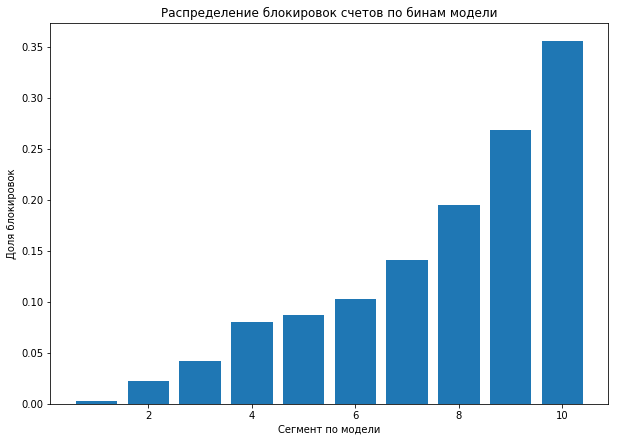

In [58]:
fig = plt.figure(figsize=(10,7))
plt.bar(data.index, data['Доля блокировок'])
plt.title('Распределение блокировок счетов по бинам модели')
plt.xlabel('Сегмент по модели')
plt.ylabel('Доля блокировок')
plt.show()

# 3. Значения для расчета финансового эффекта

### 9,5% - доля блокировок за последние 6 месяцев с 2019-09-01

### 4.7 % Доля блокировок за последние 6 месяцев с 2019-09-01 по модели с 1 по 5 сегмент

In [59]:
data.loc[lambda x: x.index<=5]['Количество блокировок'].sum() / data.loc[lambda x: x.index<=5]['Всего наблюдений'].sum()

0.04694533762057878

### Для расчета финансового эффекта возьмем предполагаемые доли блокировок 0.5% (по модели) и 0.3% (по текущему процессу или старой модели)

## 3.1 Доверительный интервал финансового эффекта

In [11]:
def get_confidence_interval(N, targets_sum):
    """
    Функция на вход получает размер выборки и кол-во таргетов
    На выходе получаем доверительный интервал
    """
    
    conv = targets_sum/N
    
    low_intrerval = conv - 1.96*np.sqrt(conv*(1-conv)/N)
    high_intrerval = conv + 1.96*np.sqrt(conv*(1-conv)/N)
    
    return low_intrerval, high_intrerval
    
    

#### Количество счетов по исходной выборке 203167   
#### По модели 1016 блокировок (0.5%)

In [19]:
# Доверительный интервал доли блокировок по модели
print('Доля блокировок', 1016/203167)
get_confidence_interval(203167, 1016)

Доля блокировок 0.005000812139766793


(0.004694078702979288, 0.0053075455765542985)

#### Количество счетов по исходной выборке 203167   
#### По процессу 610 блокировок (0.3%)

In [18]:
# Доверительный интервал доли блокировок по процессу
print('Доля блокировок', 610/203167)
get_confidence_interval(203167, 610)

Доля блокировок 0.003002456107537149


(0.0027645449197178703, 0.0032403672953564278)

## 3.2 Доверительный интервал разницы

In [14]:
def get_confidence_interval_delta(N_1, targets_sum_1, N_2, targets_sum_2):
    """
    Функция на вход получает размер выборки и кол-во таргетов для 2 выборок
    На выходе получаем доверительный интервал разницы conv2 и conv1 
    Доверительный интервал разницы второй и первой выборки
    """
    
    conv1 = targets_sum_1/N_1
    conv2 = targets_sum_2/N_2
    
    low_intrerval = conv2 - conv1 - 1.96*np.sqrt((conv1*(1-conv1)/N_2) + (conv2*(1-conv1)/N_2)) 
    high_intrerval = conv2 - conv1 + 1.96*np.sqrt((conv1*(1-conv1)/N_2) + (conv2*(1-conv1)/N_2)) 
    
    return low_intrerval, high_intrerval

In [20]:
# Доверительный интервал разницы долей блокировки
print('Дельта доли блокировок', 1016/203167 - 610/203167)
get_confidence_interval_delta(203167, 610, 203167, 1016)

Дельта доли блокировок 0.001998356032229644


(0.001609928309710927, 0.002386783754748361)

### Итоговый доверительный интервал дельты между моделью и процессом

In [27]:
print('0.002 +/-',  round(0.001998356032229644 - 0.001609928309710927, 4))

0.002 +/- 0.0004
